## Import libraries and some directories ##

In [29]:
import pathlib

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import PIL.Image
import albumentations.pytorch
import cv2
import matplotlib.pyplot as plt
from torchvision import models

from tqdm.notebook import tqdm
from typing import List, Tuple
from pytorch_lightning.loggers import WandbLogger

In [30]:
!pip install wandb

In [31]:
import wandb
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Data Preprocessing ###

In [32]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

In [33]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

IMAGE_ROOT = "/kaggle/input/landmark-recognition-2021/train"
CSV_PATH = "/kaggle/input/landmark-labels/train_with_landmark_names_fixed.csv"
IMAGE_SIZE = 224

# === Load CSV ===
df = pd.read_csv(CSV_PATH,encoding = "Latin1")

# Drop missing or malformed rows
df = df.dropna(subset=['id', 'landmark_id'])

# Ensure landmark_id is int
df['landmark_id'] = df['landmark_id'].astype(int)

# === Map landmark_id to class indices ===
landmark_id_to_idx = {lid: idx for idx, lid in enumerate(sorted(df['landmark_id'].unique()))}
df['class_idx'] = df['landmark_id'].map(landmark_id_to_idx)

In [34]:
# === Build image paths ===
def get_image_path(image_id):
    return os.path.join(
        IMAGE_ROOT, image_id[0], image_id[1], image_id[2], f"{image_id}.jpg"
    )

df['image_path'] = df['id'].apply(get_image_path)

# === Filter out missing files ===
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# === Train/Validation split ===
train_df, val_df = train_test_split(df, stratify=df['class_idx'], test_size=0.1, random_state=42)

In [35]:
image_id = "111033371fee2d05"
print(get_image_path(image_id))
# Output: /kaggle/input/landmark-recognition-2021/train/1/1/1/111033371fee2d05.jpg

/kaggle/input/landmark-recognition-2021/train/1/1/1/111033371fee2d05.jpg


In [36]:
# === Transforms ===
train_transform = A.Compose([
    A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ImageCompression(quality_lower=99, quality_upper=100),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(p=0.2),
    A.CLAHE(p=0.1),
    A.GaussianBlur(p=0.1),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(),
    ToTensorV2()
])

In [37]:
# === Custom Dataset ===
from PIL import Image
import torch

class LandmarkDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert("RGB")
        img = np.array(img)

        if self.transform:
            img = self.transform(image=img)['image']

        label = row['class_idx']
        return img, label

# === Datasets & Loaders ===
train_dataset = LandmarkDataset(train_df, transform=train_transform)
val_dataset = LandmarkDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

## DOLG
Single-Stage Image Retrieval with Deep Orthogonal Fusion of
Local and Global Features


## Torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule

In [ ]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, scale_factor=64.0, margin=0.50, criterion=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = scale_factor
        self.m = margin

        # Initialize weights for the ArcFace layer
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.criterion = criterion if criterion else nn.CrossEntropyLoss()

        # Precompute margin constants
        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m) * self.m

    def forward(self, input, label):
        # Project the input to the correct size (e.g., 512)
        input_norm = F.normalize(input, p=2, dim=1)  # [batch_size, in_features]
        weight_norm = F.normalize(self.weight, p=2, dim=1)  # [out_features, in_features]

        # Cosine similarity between input and weights
        cosine = F.linear(input_norm, weight_norm)  # [batch_size, num_classes]
        cosine = cosine.clamp(-1.0, 1.0)  # numerical stability

        # ArcFace margin adjustment
        sine = torch.sqrt(1.0 - cosine ** 2 + 1e-6)
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        # One-hot encode labels
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        # Final logits
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s  # Apply scale factor

        # Compute loss
        loss = self.criterion(output, label)

        return loss, output

In [ ]:
import torch

# Define input size and number of classes
batch_size = 8  # Example batch size
in_features = 512  # Example input feature size (e.g., from a backbone network)
out_features = 10  # Example number of classes (e.g., 10 classes)

# Create a test input (random tensor with shape [batch_size, in_features])
input_tensor = torch.randn(batch_size, in_features)

# Create a test label tensor (random labels, with shape [batch_size])
label_tensor = torch.randint(0, out_features, (batch_size,))

# Initialize ArcFace model
arcface = ArcFace(in_features=in_features, out_features=out_features)

# Pass the input through the ArcFace model
loss, output = arcface(input_tensor, label_tensor)

# Check the loss and output shapes
print("Loss:", loss.item())  # Print loss value
print("Output shape:", output.shape)  # Check output shape (should be [batch_size, num_classes])


In [ ]:
#import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule


class MultiAtrous(nn.Module):
    def __init__(self, in_channel, out_channel, size, dilation_rates=[3, 6, 9]):
        super().__init__()
        self.dilated_convs = [
            nn.Conv2d(in_channel, int(out_channel/4),
                      kernel_size=3, dilation=rate, padding=rate)
            for rate in dilation_rates
        ]
        self.gap_branch = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channel, int(out_channel/4), kernel_size=1),
            nn.ReLU(),
            nn.Upsample(size=(size, size), mode='bilinear')
        )
        self.dilated_convs.append(self.gap_branch)
        self.dilated_convs = nn.ModuleList(self.dilated_convs)

    def forward(self, x):
        local_feat = []
        for dilated_conv in self.dilated_convs:
            local_feat.append(dilated_conv(x))
        local_feat = torch.cat(local_feat, dim=1)
        return local_feat


class DolgLocalBranch(nn.Module):
    def __init__(self, in_channel, out_channel, hidden_channel=2048):
        super().__init__()
        self.multi_atrous = MultiAtrous(in_channel, hidden_channel, size=int(224/8))
        self.conv1x1_1 = nn.Conv2d(hidden_channel, out_channel, kernel_size=1)
        self.conv1x1_2 = nn.Conv2d(
            out_channel, out_channel, kernel_size=1, bias=False)
        self.conv1x1_3 = nn.Conv2d(out_channel, out_channel, kernel_size=1)

        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channel)
        self.softplus = nn.Softplus()

    def forward(self, x):
        local_feat = self.multi_atrous(x)

        local_feat = self.conv1x1_1(local_feat)
        local_feat = self.relu(local_feat)
        local_feat = self.conv1x1_2(local_feat)
        local_feat = self.bn(local_feat)

        attention_map = self.relu(local_feat)
        attention_map = self.conv1x1_3(attention_map)
        attention_map = self.softplus(attention_map)

        local_feat = F.normalize(local_feat, p=2, dim=1)
        local_feat = local_feat * attention_map
        return local_feat


class OrthogonalFusion(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, local_feat, global_feat):
        global_feat_norm = torch.norm(global_feat, p=2, dim=1)
        projection = torch.bmm(global_feat.unsqueeze(1), torch.flatten(local_feat, start_dim=2))
        projection = torch.bmm(global_feat.unsqueeze(2), projection).view(local_feat.size())
        projection = projection / (global_feat_norm * global_feat_norm).view(-1, 1, 1, 1)
        orthogonal_comp = local_feat - projection
        global_feat = global_feat.unsqueeze(-1).unsqueeze(-1)
        return torch.cat([global_feat.expand(orthogonal_comp.size()), orthogonal_comp], dim=1)

from pytorch_lightning import LightningModule
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader


class DolgNet(LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, num_of_classes, train_dataset, val_dataset):
        super().__init__()
        self.save_hyperparameters()  # Optional: logs args automatically

        self.cnn = ResNetBackbone()
        self.local_branch = DolgLocalBranch(512, hidden_dim)
        self.orthogonal_fusion = OrthogonalFusion()

        self.gem_pool = GeM()
        self.gap = nn.AdaptiveAvgPool2d(1)

        self.fc_1 = nn.Linear(1024, hidden_dim)  # for global feature processing

        # Removed fc_2 — you’re using ArcFace
        self.criterion = ArcFace(
            in_features=2 * hidden_dim,
            out_features=num_of_classes,
            scale_factor=30,
            margin=0.15,
            criterion=nn.CrossEntropyLoss()
        )

        self.lr = Config.lr
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.freeze_resnet_layers()

    def forward(self, x):
        local_feat, global_feat = self.cnn(x)

        local_feat = self.local_branch(local_feat)

        global_feat = self.gem_pool(global_feat).squeeze()
        global_feat = self.fc_1(global_feat)
        global_feat = F.normalize(global_feat, p=2, dim=1)

        feat = self.orthogonal_fusion(local_feat, global_feat)
        feat = self.gap(feat).squeeze()
        return feat

    def training_step(self, batch, batch_idx):
        x, y = batch
        embeddings = self(x)
        loss = self.criterion(embeddings, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        embeddings = self(x)
        _, logits = self.criterion(embeddings, y)
        confs, preds = torch.max(torch.softmax(logits, dim=1), dim=1)

        return {
            "preds": preds.cpu().numpy(),
            "labels": y.cpu().numpy(),
            "confs": confs.cpu().numpy()
        }

    def training_epoch_end(self, outputs):
        # outputs is list of scalars
        avg_loss = torch.stack(outputs).mean()
        self.log("avg_train_loss", avg_loss, prog_bar=True)

    def validation_epoch_end(self, outputs):
        all_preds, all_labels, all_confs = [], [], []
        for out in outputs:
            all_preds.extend(out["preds"])
            all_labels.extend(out["labels"])
            all_confs.extend(out["confs"])

        gap = compute_gap(all_preds, all_confs, all_labels)
        self.log("val_gap", gap, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=0.9, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.epochs)
        return [optimizer], [scheduler]

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=32,
                          shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=32,
                          shuffle=False, num_workers=2)

In [ ]:
class DolgNet(LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, num_of_classes, train_dataset, val_dataset):
        super().__init__()
        self.cnn = ResNetBackbone()  # Returns (local_feat, global_feat)
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.local_branch = DolgLocalBranch(512, hidden_dim)
        self.gem_pool = GeM()
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fusion & projection
        self.orthogonal_fusion = OrthogonalFusion()
        self.fc_proj = nn.Linear(hidden_dim + 512, 512)  # local + global -> ArcFace

        # ArcFace loss
        self.criterion = ArcFace(
            in_features=512,
            out_features=num_of_classes,
            scale_factor=30,
            margin=0.15,
            criterion=nn.CrossEntropyLoss()
        )
        self.lr = 2e-4
        self.freeze_resnet_layers()

    def forward(self, x):
        # Backbone output
        local_feat, global_feat = self.cnn(x)  # local: [B, 512, 28, 28], global: [B, 2048, H, W]

        # Local branch
        local_feat = self.local_branch(local_feat)  # [B, hidden_dim, H, W]
        local_feat = self.gap(local_feat).squeeze(-1).squeeze(-1)  # [B, hidden_dim]

        # Global branch
        global_feat = self.gem_pool(global_feat).view(global_feat.size(0), -1)  # [B, 2048]
        global_feat = F.normalize(global_feat, p=2, dim=1)
        global_feat = nn.Linear(2048, 512)(global_feat)  # Inline or define self.global_proj if reused
        global_feat = F.normalize(global_feat, p=2, dim=1)

        # Fusion
        fused_feat = self.orthogonal_fusion(local_feat, global_feat)  # [B, hidden_dim + 512]
        fused_feat = self.fc_proj(fused_feat)  # [B, 512]
        fused_feat = F.normalize(fused_feat, p=2, dim=1)

        return fused_feat

    def freeze_resnet_layers(self):
        layers_to_freeze = ['stem', 'layer1', 'layer2']
        
        for layer_name in layers_to_freeze:
            layer = getattr(self.cnn, layer_name)
            for param in layer.parameters():
                param.requires_grad = False
            print(f"Froze {layer_name}")
    
        # Ensure layer3 is trainable
        for param in self.cnn.layer3.parameters():
            param.requires_grad = True
        print("Layer3 is trainable")
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        feats = self.forward(x)
        loss, logits = self.criterion(feats, y)
        self.log('train_loss', loss)
        return loss


    def validation_step(self, batch, batch_idx):
        img, label = batch
        embd = self(img)
        _, logits = self.criterion(embd, label)
    
        confs, preds = torch.max(torch.softmax(logits, dim=1), dim=1)
    
        return {
            "preds": preds.cpu().numpy(),
            "labels": label.cpu().numpy(),
            "confs": confs.cpu().numpy()
        }
    
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.lr,
                              momentum=0.9, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=1000)
        return [optimizer], [scheduler]

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack(outputs).mean()
        self.log('avg_train_loss', avg_loss, prog_bar=True)

    def validation_epoch_end(self, outputs):
        all_preds = []
        all_labels = []
        all_confs = []
    
        for out in outputs:
            all_preds.extend(out['preds'])
            all_labels.extend(out['labels'])
            all_confs.extend(out['confs'])

        gap = compute_gap(all_preds, all_confs, all_labels)
        self.log("val_gap", gap, prog_bar=True, logger=True)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=32, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=32, shuffle=False, num_workers=2)


## Rebuild The project starts from here

### Loading data and images with albumentations

In [10]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch

# === Config ===
IMAGE_ROOT = "/kaggle/input/landmark-recognition-2021/train"
CSV_PATH = "/kaggle/input/landmark-labels/train_with_landmark_names_fixed.csv
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4

# === Load and preprocess CSV ===
df = pd.read_csv(CSV_PATH, encoding="Latin1")
df = df.dropna(subset=['id', 'landmark_id'])
df['landmark_id'] = df['landmark_id'].astype(int)

# Map landmark IDs to class indices
landmark_id_to_idx = {lid: idx for idx, lid in enumerate(sorted(df['landmark_id'].unique()))}
df['class_idx'] = df['landmark_id'].map(landmark_id_to_idx)

# Generate full image paths
def get_image_path(image_id):
    return os.path.join(IMAGE_ROOT, image_id[0], image_id[1], image_id[2], f"{image_id}.jpg")

df['image_path'] = df['id'].apply(get_image_path)
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# === Train/Val Split ===
train_df, val_df = train_test_split(df, stratify=df['class_idx'], test_size=0.1, random_state=42)

# === Custom Dataset ===
class LandmarkDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            img = Image.open(row['image_path']).convert("RGB")
            img = np.array(img)
        except Exception as e:
            print(f"Failed to load image {row['image_path']}: {e}")
            # Skip this sample if image loading fails
            return self.__getitem__((idx + 1) % len(self.df))  # Skip this sample

        if self.transform:
            img = self.transform(image=img)['image']

        label = row['class_idx']
        return img, label

train_transform = A.Compose([
    A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(p=0.2),
    A.CLAHE(p=0.1),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Using ResNet mean & std
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Same mean & std as train
    ToTensorV2()
])

# === DataLoaders ===
train_dataset = LandmarkDataset(train_df, transform=train_transform)
val_dataset = LandmarkDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# === DataLoaders ===
train_dataset = LandmarkDataset(train_df, transform=train_transform)
val_dataset = LandmarkDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [38]:
# Check if train and val datasets are non-empty
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")


Training dataset size: 43686
Validation dataset size: 4855


In [39]:
# Check if data is loading properly by fetching one batch
train_iter = iter(train_loader)
val_iter = iter(val_loader)

# Try loading the first batch from the train set
train_images, train_labels = next(train_iter)
print(f"Train batch - Images shape: {train_images.shape}, Labels shape: {train_labels.shape}")

# Try loading the first batch from the validation set
val_images, val_labels = next(val_iter)
print(f"Val batch - Images shape: {val_images.shape}, Labels shape: {val_labels.shape}")


Train batch - Images shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Val batch - Images shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])


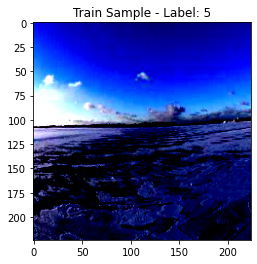

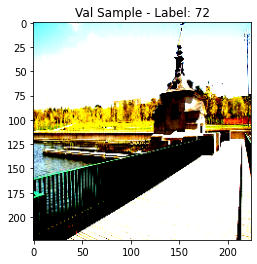

In [40]:
import matplotlib.pyplot as plt

# Get a sample from the training set
train_img, train_label = train_loader.dataset[0]  # First sample from train dataset
plt.imshow(train_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.title(f"Train Sample - Label: {train_label}")
plt.show()

# Get a sample from the validation set
val_img, val_label = val_loader.dataset[0]  # First sample from val dataset
plt.imshow(val_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.title(f"Val Sample - Label: {val_label}")
plt.show()


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# === File paths ===
TRAIN_CSV = '/kaggle/input/landmark-recognition-2021/train.csv'
TRAIN_DIR = '/kaggle/input/landmark-recognition-2021/train'
OUTPUT_CSV = 'train_top_100_classes.csv'  # This will save to the working directory

# === Load the full training CSV ===
df = pd.read_csv(TRAIN_CSV)

# === Drop rows with missing landmark_id ===
df = df.dropna(subset=['landmark_id'])

# === Get top 100 most frequent landmark_ids ===
top_100_ids = df['landmark_id'].value_counts().nlargest(100).index

# === Filter dataset to keep only top 100 landmark_ids ===
df = df[df['landmark_id'].isin(top_100_ids)].copy()

# === Remap landmark_id to new_id (0 to 99) ===
unique_ids = sorted(df['landmark_id'].unique())
id_to_new_id = {old: new for new, old in enumerate(unique_ids)}
df['new_id'] = df['landmark_id'].map(id_to_new_id)

# === Build image paths ===
def make_path(img_id):
    return os.path.join(TRAIN_DIR, f'{img_id[0]}/{img_id[1]}/{img_id[2]}/{img_id}.jpg')

df['path'] = df['id'].apply(make_path)

# === Remove rows with non-existing image paths (optional but recommended) ===
df = df[df['path'].apply(os.path.exists)]

# === Save to CSV for reproducibility ===
df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved filtered dataset with top 100 classes to: {OUTPUT_CSV}")

# === Train/Val/Test split ===
X_train, X_temp, y_train, y_temp = train_test_split(
    df[['id', 'path']], df['new_id'],
    train_size=0.8,
    stratify=df['new_id'],
    random_state=123,
    shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    train_size=0.5,
    stratify=y_temp,
    random_state=123,
    shuffle=True
)

# === Confirm splits ===
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == df.shape[0]
print(f"Train: {X_train.shape[0]} samples, {y_train.nunique()} classes")
print(f"Val:   {X_val.shape[0]} samples, {y_val.nunique()} classes")
print(f"Test:  {X_test.shape[0]} samples, {y_test.nunique()} classes")

In [ ]:
print("Class distribution in train set:")
print(y_train.value_counts(normalize=True).head())

print("\nClass distribution in val set:")
print(y_val.value_counts(normalize=True).head())

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True).head())

In [51]:
# Classes distribution on training, validation and test sets
plt.figure(figsize = (10, 3))
ax = sns.histplot(y_train, bins=75, kde = True)
ax.set_title('Distribution of Landmarks on training set')
plt.tight_layout()

plt.figure(figsize = (10, 3))
ax = sns.histplot(y_val, bins=75, kde = True)
ax.set_title('Distribution of Landmarks on validation set')
plt.tight_layout()

plt.figure(figsize = (10, 3))
ax = sns.histplot(y_test, bins=75, kde = True)
ax.set_title('Distribution of Landmarks on test set')
plt.tight_layout()
plt.show()

NameError: name 'sns' is not defined

<Figure size 720x216 with 0 Axes>

In [ ]:
import shutil
# Creating image directories for classes subset
NEW_BASE_DIR = "/kaggle/working"

# Training set directory
for file, path, landmark in tqdm(zip(X_train['id'], X_train['path'], y_train)):
    dir = f"{NEW_BASE_DIR}/train_sub/{str(landmark)}"
    os.makedirs(dir, exist_ok = True)
    fname = f"{file}.jpg"
    shutil.copyfile(src = path, dst = f"{dir}/{fname}")

# Validation set directory    
for file, path, landmark in tqdm(zip(X_val['id'], X_val['path'], y_val)):
    dir = f"{NEW_BASE_DIR}/val_sub/{str(landmark)}"
    os.makedirs(dir, exist_ok = True)
    fname = f"{file}.jpg"
    shutil.copyfile(src = path, dst = f"{dir}/{fname}")

# Testing set directory
for file, path, landmark in tqdm(zip(X_test['id'], X_test['path'], y_test)):
    dir = f"{NEW_BASE_DIR}/test_sub/{str(landmark)}"
    os.makedirs(dir, exist_ok = True)
    fname = f"{file}.jpg"
    shutil.copyfile(src = path, dst = f"{dir}/{fname}")

In [ ]:
# Creating tensorflow tf.data.Dataset
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = 224
BATCH_SIZE = 16

print("Building training dataset...")
# Training tf.data.Dataset
train_ds = image_dataset_from_directory(f"{NEW_BASE_DIR}/train_sub",
                                        label_mode = 'int',
                                        shuffle = True,
                                        image_size = (IMG_SIZE, IMG_SIZE),
                                        batch_size = BATCH_SIZE)

print("Building validation dataset...")
# Validation tf.data.Dataset
val_ds = image_dataset_from_directory(f"{NEW_BASE_DIR}/val_sub",
                                        label_mode = 'int',
                                        shuffle = True,
                                        image_size = (IMG_SIZE, IMG_SIZE),
                                        batch_size = BATCH_SIZE)

print("Building test dataset...")
# Test tf.data.Dataset
test_ds = image_dataset_from_directory(f"{NEW_BASE_DIR}/test_sub",
                                        label_mode = 'int',
                                        shuffle = True,
                                        image_size = (IMG_SIZE, IMG_SIZE),
                                        batch_size = BATCH_SIZE)

In [ ]:
# Visualizing a random batch from training dataset
for data_batch, labels_batch in train_ds.take(1):
    ncols = 4
    nrows = int(data_batch.shape[0]/ncols)
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(10, 11),
                           sharex = True, sharey = True)
    img_counter = 0
    for image, label in zip(data_batch, labels_batch):
        axi = ax.flat[img_counter]
        axi.imshow(image/255.)
        label = label.numpy()
#         axi.set_title(np.where(label == 1)[0])
        axi.set_title(label)
        img_counter += 1
plt.show()

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 16

# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

# === PyTorch Dataset Loaders ===
train_dataset = datasets.ImageFolder(root=f"{NEW_BASE_DIR}/train_sub", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{NEW_BASE_DIR}/val_sub", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{NEW_BASE_DIR}/test_sub", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


### The DOLG model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F


class AttentionFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels, 1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, local_feat, global_feat):
        b, c, h, w = local_feat.shape
        global_feat_expanded = global_feat.view(b, c, 1, 1).expand(-1, -1, h, w)
        attn = self.attn(local_feat + global_feat_expanded)
        fused = local_feat * attn + global_feat_expanded * (1 - attn)
        return fused

In [ ]:
class NonLocalBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.inter_channels = in_channels // 2

        self.g = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.theta = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.phi = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.W = nn.Conv2d(self.inter_channels, in_channels, kernel_size=1)
        nn.init.constant_(self.W.weight, 0)
        nn.init.constant_(self.W.bias, 0)

    def forward(self, x):
        batch_size, C, H, W = x.size()

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)  # [B, C', N]
        g_x = g_x.permute(0, 2, 1)  # [B, N, C']

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)  # [B, C', N]
        theta_x = theta_x.permute(0, 2, 1)  # [B, N, C']

        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)  # [B, C', N]

        f = torch.matmul(theta_x, phi_x)  # [B, N, N]
        f_div_C = F.softmax(f, dim=-1)

        y = torch.matmul(f_div_C, g_x)  # [B, N, C']
        y = y.permute(0, 2, 1).contiguous().view(batch_size, self.inter_channels, H, W)
        W_y = self.W(y)

        return W_y + x  # residual connection

In [ ]:
import math

class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.3):
        super(ArcFace, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.s = s
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, labels):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # [B, C]
        sine = torch.sqrt((1.0 - cosine ** 2).clamp(min=0.0))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(θ + m)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        logits = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        logits *= self.s
        return logits

In [ ]:
class DOLG_ArcFace(nn.Module):
    def __init__(self, embedding_dim=512):
        super().__init__()
        resnet = models.resnet50(pretrained=True)

        # Shared layers
        self.backbone_common = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu,
            resnet.maxpool, resnet.layer1,
            resnet.layer2, resnet.layer3
        )

        # Global branch
        self.backbone_global = resnet.layer4
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.global_fc = nn.Linear(2048, embedding_dim)

        # Local branch with multi-atrous conv + 1x1 projection
        self.local_branch = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1, dilation=1),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=3, dilation=3),
            nn.ReLU(),
        )
        self.local_proj = nn.Conv2d(512 * 3, embedding_dim, kernel_size=1)

        # Non-local block for self-attention
        self.self_attn = NonLocalBlock(embedding_dim)

        self.fusion = AttentionFusion(embedding_dim)

        self.head = nn.Sequential(
            nn.Conv2d(embedding_dim, embedding_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

    def forward(self, x):
        shared_feat = self.backbone_common(x)  # Output: [B, 1024, H, W]

        # Global branch
        global_feat_map = self.backbone_global(shared_feat)  # Output: [B, 2048, H/2, W/2]
        global_feat = self.global_pool(global_feat_map).view(x.size(0), -1)  # [B, 2048]
        global_feat = self.global_fc(global_feat)  # [B, 512]

        # Local branch with atrous conv
        feat1 = F.relu(self.local_branch[0](shared_feat))
        feat2 = F.relu(self.local_branch[2](shared_feat))
        feat3 = F.relu(self.local_branch[4](shared_feat))
        local_feat = torch.cat([feat1, feat2, feat3], dim=1)  # [B, 512*3, H, W]
        local_feat = self.local_proj(local_feat)  # [B, 512, H, W]

        # Apply self-attention (only once)
        local_feat = self.self_attn(local_feat)

        # Fusion
        fused_feat = self.fusion(local_feat, global_feat)  # [B, 512, H, W]
        emb = self.head(fused_feat)  # [B, 512]
        return emb

In [ ]:
class DOLG_ArcFace(nn.Module):
    def __init__(self, embedding_dim=512):
        super().__init__()
        resnet = models.resnet50(pretrained=True)

        # Shared layers
        self.backbone_common = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu,
            resnet.maxpool, resnet.layer1,
            resnet.layer2, resnet.layer3
        )

        # ResNet layer4 expects input with 1024 channels (not from local_conv!)
        self.backbone_global = resnet.layer4

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.global_fc = nn.Linear(2048, embedding_dim)

        self.local_branch = nn.Sequential(
        nn.Conv2d(1024, 512, kernel_size=3, padding=1, dilation=1),
        nn.Conv2d(1024, 512, kernel_size=3, padding=2, dilation=2),
        nn.Conv2d(1024, 512, kernel_size=3, padding=3, dilation=3),
    # Concatenate all, then project back with 1x1 conv
)

        self.fusion = AttentionFusion(embedding_dim)

        self.head = nn.Sequential(
            nn.Conv2d(embedding_dim, embedding_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

    def forward(self, x):
        shared_feat = self.backbone_common(x)  # Output: [B, 1024, H, W]

        # Global branch
        global_feat_map = self.backbone_global(shared_feat)  # Output: [B, 2048, H/2, W/2]
        global_feat = self.global_pool(global_feat_map).view(x.size(0), -1)  # [B, 2048]
        global_feat = self.global_fc(global_feat)  # [B, 512]

        # Local branch
        local_feat = self.local_conv(shared_feat)  # [B, 512, H, W]

        # Fuse
        fused_feat = self.fusion(local_feat, global_feat)  # [B, 512, H, W]
        emb = self.head(fused_feat)  # [B, 512]
        return emb

### Tạo tập train/val  

In [15]:
import numpy as np

# === Train/Val Split ===
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['class_idx'], random_state=42)
train_df = train_df.copy()
val_df = val_df.copy()

train_df['image_path'] = train_df['id'].apply(lambda x: os.path.join(IMAGE_ROOT, f"{x[0]}/{x[1]}/{x[2]}/{x}.jpg"))
val_df['image_path'] = val_df['id'].apply(lambda x: os.path.join(IMAGE_ROOT, f"{x[0]}/{x[1]}/{x[2]}/{x}.jpg"))

# === Reload Datasets with correct DataFrames ===
train_dataset = LandmarkDataset(train_df, transform=train_transform)
val_dataset = LandmarkDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

### Training process

In [20]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/kaggle/input/landmark-labels/train_with_landmark_names_fixed.csv")

# Get the number of unique landmark_id
unique_landmarks = df['landmark_id'].nunique()

print(f"Number of unique landmark classes: {unique_landmarks}")


Number of unique landmark classes: 102


In [21]:
num_classes = 102

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = DOLG_ArcFace().to(device)
arcface_head = ArcFace(512, num_classes).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(arcface_head.parameters()), lr=1e-4)

# Training loop:
for imgs, labels in train_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    optimizer.zero_grad()
    embeddings = model(imgs)  # [B, 512]
    logits = arcface_head(embeddings, labels)  # [B, num_classes]
    #logits = head(embeddings)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

In [ ]:
import wandb

wandb.init(project="landmark-recognition", name="resnet-arcface-final", config={
    "epochs": 30,
    "batch_size": 32,
    "image_size": IMAGE_SIZE,
    "embedding_dim": 512,
    "optimizer": "Adam",
    "lr": 1e-4
})

### Evaluation define

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, top_k_accuracy_score, confusion_matrix
import numpy as np

In [ ]:
def compute_gap(preds, confs, targets):
    df = pd.DataFrame({
        "pred": preds,
        "conf": confs,
        "target": targets
    })
    df = df.sort_values("conf", ascending=False).reset_index(drop=True)

    correct = 0
    total_precision = 0.0

    for i, row in df.iterrows():
        if row["pred"] == row["target"]:
            correct += 1
            total_precision += correct / (i + 1)

    return total_precision / len(df)

### New train code => Final results

In [ ]:
criterion = nn.CrossEntropyLoss()

In [45]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['class_idx'] = le.fit_transform(df['class_idx'])


In [46]:
num_classes = len(df['class_idx'].unique())
arcface_head = ArcFace(in_features=512, out_features=num_classes)


In [ ]:
import wandb
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize wandb
#wandb.init(project="landmark-recognition", name="resnet-dolg-arcface")

best_gap = 0.0
num_epochs = 30

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
gap_scores = []

# Scheduler: Reduce LR when GAP plateaus
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,      # Reduce LR by half
    patience=2,      # Wait 2 epochs without improvement
    min_lr=1e-6,     # Prevent LR from becoming too small
    verbose=True
)

for epoch in range(num_epochs):
    model.train()
    arcface_head.train()

    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        embeddings = model(imgs)
        logits = arcface_head(embeddings, labels)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # === Validation + GAP ===
    model.eval()
    arcface_head.eval()

    val_loss = 0.0
    val_correct = 0
    val_total = 0

    all_preds = []
    all_confs = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            embeddings = model(imgs)
            logits = arcface_head(embeddings, labels)
            loss = criterion(logits, labels)

            val_loss += loss.item()

            probs = F.softmax(logits, dim=1)
            confs, preds = torch.max(probs, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_confs.extend(confs.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    gap_score = compute_gap(all_preds, all_confs, all_labels)

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%, GAP: {gap_score:.4f}")

    # Step the LR scheduler
    scheduler.step(gap_score)

    # Log to wandb
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "gap": gap_score,
        "lr": optimizer.param_groups[0]['lr']  # log current LR
    })

    # Save best model
    if gap_score > best_gap:
        best_gap = gap_score
        torch.save({
            "model_state_dict": model.state_dict(),
            "arcface_state_dict": arcface_head.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "gap": gap_score,
            "epoch": epoch + 1
        }, "best_model.pth")
        print("✅ Saved new best model with GAP:", best_gap)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    gap_scores.append(gap_score)

    # === Plotting ===
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # GAP Score
    plt.subplot(1, 3, 3)
    plt.plot(gap_scores, label='GAP')
    plt.title('GAP Score')
    plt.xlabel('Epoch')
    plt.legend()

    plt.suptitle(f"Training Metrics - Epoch {epoch+1}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Save checkpoint

In [ ]:
checkpoint = torch.load("best_model.pth", map_location=device)

model = DOLG_ArcFace().to(device)
arcface_head = ArcFace(512, num_classes).to(device)

model.load_state_dict(checkpoint["model_state_dict"])
arcface_head.load_state_dict(checkpoint["arcface_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('/kaggle/working/best_model.pth')

In [ ]:
import shutil
dst_dir = 'kaggle/working/'
!zip -r folder.zip /kaggle/working/best_model.pth

In [ ]:
from IPython.display import FileLink
FileLink(r'folder.zip')

In [ ]:
DOLG_model_dict = "/kaggle/input/resnet-dolg/kaggle/working/best_model.pth"
test_image_link = "/kaggle/input/test-landmark-images/eiffel.jpg"

In [ ]:
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom dataset wrapper for a single image
class SingleImageDataset(Dataset):
    def __init__(self, image_path, label=0, transform=None):
        self.image_path = image_path
        self.label = label
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image = Image.open(self.image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.label

In [ ]:
checkpoint = torch.load(DOLG_model_dict, map_location=device)

# Load model weights
model = DOLG_ArcFace(embedding_dim=512).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

# Load ArcFace head (you must define this first with correct output classes)
arcface_head = ArcFace(in_features=512, out_features=102).to(device)
arcface_head.load_state_dict(checkpoint['arcface_state_dict'])

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Match training normalization
])

In [ ]:
# Path to test image
test_image_link = "/kaggle/input/test-landmark-images/eiffel.jpg"

# Dummy label (for ArcFace input; only needed to compute logits)
test_dataset = SingleImageDataset(test_image_link, label=0, transform=transform)

# Run visualization
show_predictions(model, arcface_head, test_dataset, num_images=1)

## Demo
Đây là các phần cần có để có thể chạy demo cho ResNet+DOLG

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F


class AttentionFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels, 1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, local_feat, global_feat):
        b, c, h, w = local_feat.shape
        global_feat_expanded = global_feat.view(b, c, 1, 1).expand(-1, -1, h, w)
        attn = self.attn(local_feat + global_feat_expanded)
        fused = local_feat * attn + global_feat_expanded * (1 - attn)
        return fused

In [ ]:
import math

class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.3):
        super(ArcFace, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.s = s
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, labels):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # [B, C]
        sine = torch.sqrt((1.0 - cosine ** 2).clamp(min=0.0))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(θ + m)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        logits = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        logits *= self.s
        return logits

In [ ]:
class DOLG_ArcFace(nn.Module):
    def __init__(self, embedding_dim=512):
        super().__init__()
        resnet = models.resnet50(pretrained=True)

        # Shared layers
        self.backbone_common = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu,
            resnet.maxpool, resnet.layer1,
            resnet.layer2, resnet.layer3
        )

        # ResNet layer4 expects input with 1024 channels (not from local_conv!)
        self.backbone_global = resnet.layer4

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.global_fc = nn.Linear(2048, embedding_dim)

        self.local_conv = nn.Conv2d(1024, embedding_dim, kernel_size=1)

        self.fusion = AttentionFusion(embedding_dim)

        self.head = nn.Sequential(
            nn.Conv2d(embedding_dim, embedding_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

    def forward(self, x):
        shared_feat = self.backbone_common(x)  # Output: [B, 1024, H, W]

        # Global branch
        global_feat_map = self.backbone_global(shared_feat)  # Output: [B, 2048, H/2, W/2]
        global_feat = self.global_pool(global_feat_map).view(x.size(0), -1)  # [B, 2048]
        global_feat = self.global_fc(global_feat)  # [B, 512]

        # Local branch
        local_feat = self.local_conv(shared_feat)  # [B, 512, H, W]

        # Fuse
        fused_feat = self.fusion(local_feat, global_feat)  # [B, 512, H, W]
        emb = self.head(fused_feat)  # [B, 512]
        return emb

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

def predict_image(image_path, model, arcface_head, transform, device, idx_to_landmark_id=None, id_to_name=None):
    model.eval()
    arcface_head.eval()

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    label_tensor = torch.tensor([0], device=device)

    # Forward pass
    with torch.no_grad():
        embedding = model(input_tensor)
        logits = arcface_head(embedding, label_tensor)
        probs = F.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)

    pred_idx = pred.item()
    confidence = conf.item()

    if idx_to_landmark_id:
        pred_landmark_id = idx_to_landmark_id.get(pred_idx, "Unknown ID")
    else:
        pred_landmark_id = pred_idx

    if id_to_name:
        pred_name = id_to_name.get(pred_landmark_id, "Unknown Landmark")
    else:
        pred_name = f"Class {pred_idx}"

    print(f"Predicted: {pred_name} (ID: {pred_landmark_id}) | Confidence: {confidence:.2f}")
    return pred_idx, confidence

In [ ]:
# ---- Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
NUM_CLASSES = 102
model = DOLG_ArcFace(embedding_dim=512).to(device)
arcface_head = ArcFace(in_features=512, out_features=NUM_CLASSES).to(device)  # Replace NUM_CLASSES

# Load checkpoint
checkpoint = torch.load("/kaggle/input/resnet-dolg/ResNetDOLG.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
arcface_head.load_state_dict(checkpoint['arcface_state_dict'])

# Image transform (must match training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Optional mappings
idx_to_landmark_id = {v: k for k, v in landmark_id_to_idx.items()}
landmark_id_to_name = {
    27: "Isa Khan Niyazi's tomb",
    # ... fill from your metadata
}

# ---- Predict ----
image_path = "/kaggle/input/test-landmark-images/golden_gate_foggy.jpg"
predict_image(
    image_path,
    model,
    arcface_head,
    transform,
    device,
    idx_to_landmark_id=idx_to_landmark_id,
    id_to_name=landmark_id_to_name
)
